# Text Classification using Doc2Vec and Tf-idf

 - A Thinkful Final Capstone

This notebook is a high level summary of my text classification project.

### Motivation

Throughout the bootcamp, I was inspired by mathematics lectures that I watched to supplement the material I was learning.  By the end of the bootcamp, I chose NLP as my specialization so I decided to combine the two as basis of my project. The idea was to process the subtitles of the lectures, then use various methods to classify them.

Throughout the project I had numerous opportunities to familiarize my self with new powerful tools one of which is Doc2Vec, word2vec embedding for documents. (functions similarily) Another tool would to be making api calls and scraping information I needed while avoid the quotas. Lastly, I attemped numerous nerual netorks to classify my texts, however the model performed terribly.

  # Collecting the data

#### Youtube API

For the youtube API, I wrote two initial functions.
    - 1. A function to return a list of video ids for a particular search term
    - 2. A function to return a list of video Ids by playlist id

The full scraping notebook can be found here : https://github.com/ExtraLime/math_lectures2/blob/master/mathscraper.ipynb

I then gathered a list of playlist Ids by browsing youtube.  Here is one of two lists I used

In [5]:
import pandas as pd
playlists = pd.read_csv('playlists_math.csv')
playlists.head(10)

,PlaylistID,LectureName
0,PLUl4u3cNGP60hI9ATjSFgLZpbNJ7myAg6,Introduction to Probability
1,PLUl4u3cNGP60uVBMaoNERc6knT_MgPKS0,Intro to Statistics
2,PLUl4u3cNGP63WbdFxL8giv4yhgdMGaZNA,Into Computer Science
3,PLUl4u3cNGP61Oq3tWYp6V_F-5jb5L2iHb,Intro Algorithms
4,PLUl4u3cNGP63gFHB6xb-kVBiQHYe_4hSi,Artificial Intel
5,PL590CCC2BC5AF3BC1,Single Var Calculus
6,PL4C4C8A7D06566F38,Multi Var Calculus
7,PLE7DDD91010BC51F8,Linear Algebra
8,PLEC88901EBADDD980,Differential Equations
9,PL221E2BBF13BECF6C,Linear Algebra


With a list of desired playlists in hand, I wrote another function to call the youtube api and collect a list of videos for each playlist along with some other information. Here is the output:

In [29]:
video_df = pd.read_csv('video_df.csv')
print('Total Video Ids:{}'.format(len(video_df.videoids)))
video_df.head(2)

Total Video Ids:1285


,title,description,channelid,videoids,playlist_id
0,L01.1 Lecture Overview,"MIT RES.6-012 Introduction to Probability, Spr...",MIT OpenCourseWare,1uW3qMFA9Ho,PLUl4u3cNGP60hI9ATjSFgLZpbNJ7myAg6
1,L01.2 Sample Space,"MIT RES.6-012 Introduction to Probability, Spr...",MIT OpenCourseWare,iQ2edOqEQAs,PLUl4u3cNGP60hI9ATjSFgLZpbNJ7myAg6


With a list of 'videoids', I wrote another api call to download the subtitles for each video. I kept hitting my quota.

To avoid waiting days inbetween scraping, I used a library called youtube -dl. However the way I used it was less traditional, here is the code.

In [11]:
def get_all_ccs(vids):
    base_url = 'https://www.youtube.com/watch?v='
    lang="en"
    for vid in vids:
        url = base_url + vid
        cmd = ["youtube-dl","--skip-download","--write-sub",
               "--sub-lang",lang,url]
        os.system(" ".join(cmd))

As you can see, it takes in a list of videoids, iterates over the list and downloads the subtitles for each video.  You may notice that it is actually sending a commad to the operating system, with the video id. The command downloads the subtitle (.vtt) file in the working directory.

After downloading the subtitles, you end up with a number of .vtt files. After creating a list of .vtt files (in the current working directory) with this code:

In [14]:
import os
filenames_vtt = [os.fsdecode(file) for file in os.listdir(os.getcwd())\
                                 if os.fsdecode(file).endswith(".vtt")]

I wrote another function that takes in this list:

In [15]:
def convert_vtt(filenames):    
    #create an assets folder if one does not yet exist
    if os.path.isdir('{}/assets'.format(os.getcwd())) == False:
        os.makedirs('assets')
    #extract the text and times from the vtt file
    for file in filenames:
        captions = webvtt.read(file)
        text_time = pd.DataFrame()
        text_time['text'] = [caption.text for caption in captions]
        text_time['start'] = [caption.start for caption in captions]
        text_time['stop'] = [caption.end for caption in captions]
        text_time.to_csv('assets/{}.csv'.format(file[:-4]),index=False) #-4 to remove '.vtt'
        #remove files from local drive
        os.remove(file)

The purpose of this function is to extract the text out of the subtitle file. It works like this:
    - 1. It checks to see if there is not an assets directy, if not, it creates one.
    - 2. It then creates a dataframe
    - 3. Extracts text, start time, stop time for each line in the .vtt
    - 4. Writes file to disk as a .csv  in the newly created (or existing) assets folder.
    - 5. Deletes the .vtt file.

So now we have the text from each lecture in a csv file. To centralize the documents, we list the csv files in the /assets directory using similar code above, only now we rename the files in the directory, removing the spaces r(\s+) to avoid errors when loading the files later.

In [19]:
#Get a list of the CSV files 
csv_files = [os.fsdecode(file) for file in os.listdir(os.getcwd()+'/assets') \
                    if os.fsdecode(file).endswith('.csv')]

In [20]:
#rename files without spaces
path = os.getcwd()+'/assets'
for filename in csv_files:
    os.rename(os.path.join(path, filename), os.path.join(path, filename.replace(' ', '')))

In [21]:
#list csv files
clean_csv = sorted([os.fsdecode(file) for file in os.listdir(os.getcwd()+'/assets')])

With a list of .csv files now we can stack information we want in one DataFrame()

In [22]:
#extrat the text and videoid
vidText = []
csv_vidid = []
path = os.getcwd()+'/assets/'
for file in clean_csv:    
    df = pd.read_csv(path+file)
    text = " ".join(df.text)
    vidText.append(text)
    csv_vidid.append(file[-18:-7]) #only the video id

You can see that this loops over each filename, loading it and extracting the videoid and the text. Then we construct a new DataFrame.

In [23]:
#set up a data frame with the available caption information
lectures_df = pd.DataFrame()
lectures_df['lecture_title'] = clean_csv
lectures_df['lecture_text'] = vidText
lectures_df['vid_id'] = csv_vidid

In [25]:
lectures_df.head(3)

,lecture_title,lecture_text,vid_id
0,'Shifting'transformbymultiplyingfunctionbyexpo...,Now I think is a good time\nto add some notati...,_X_QwpXsdOs
1,(correction)scalarmultiplicationofrow_Matrixtr...,I want to make a quick\ncorrection or clarific...,WY6QG0mZ7uQ
2,"1.AlgorithmicThinking,PeakFinding-HtSuA80QTyo....",The following\ncontent is provided under a Cre...,HtSuA80QTyo


Now we have two DataFrames we need to put together.  The video_df that has the list of videoids we *wanted* to download and the other data frame has the text and the videoids that we **actually** downloaded.

We join these dfs on using the videoids as the key:

In [30]:
base_df = lectures_df.set_index('vid_id').join(video_df.set_index('videoids')).reset_index()

In [32]:
base_df.head(2)

,index,lecture_title,lecture_text,title,description,channelid,playlist_id
0,--lPz7VFnKI,"Lec39_MIT18.01SingleVariableCalculus,Fall2007-...",The following content is\nprovided under a Cre...,"Lec 39 | MIT 18.01 Single Variable Calculus, F...",Lecture 39: Final review\nInstructor: David Je...,MIT OpenCourseWare,PL590CCC2BC5AF3BC1
1,-630YTQEuCI,S01.0MathematicalBackgroundOverview--630YTQEuC...,"In this sequence of segments,\nwe review some ...",S01.0 Mathematical Background Overview,"MIT RES.6-012 Introduction to Probability, Spr...",MIT OpenCourseWare,PLUl4u3cNGP60hI9ATjSFgLZpbNJ7myAg6


The reasoning for the join is that this allows you to keep track of the meta data for the videos that you actually downloaded. (It was the case that some videos in the list did not have subtitles available, they were simply skipped by youtube -dl)

In [48]:
base_df.shape

(867, 7)

# Cleaning the data

Now that we have a base data frame, we need to label the data and clean up the text.
you can find the full code to do that data clean up tools here: 

To the label the data, I created a dictionary with the keys and the playlist id and the subject as the value:

In [100]:
lectures = pd.read_csv('math2019.csv')
lectures.head(1)


,lecture_title,lecture_text,title,description,channelid,playlist_id,vidid
0,"Lec39_MIT18.01SingleVariableCalculus,Fall2007-...",The following content is\nprovided under a Cre...,"Lec 39 | MIT 18.01 Single Variable Calculus, F...",Lecture 39: Final review\nInstructor: David Je...,MIT OpenCourseWare,PL590CCC2BC5AF3BC1,--lPz7VFnKI


In [90]:
#load playlist csv, with a correction, libreoffice made -XZf >>Xzf
playlist_ids = pd.read_csv('playlists_math.csv')
playlist_ids.iloc[17].PlaylistID = 'PLUl4u3cNGP61hsJNdULdudlRL493b-XZf'
playlist_ids.head(1)

,PlaylistID,LectureName
0,PLUl4u3cNGP60hI9ATjSFgLZpbNJ7myAg6,Introduction to Probability


In [91]:
subject_keys = playlist_ids.PlaylistID
subject_values = ['Probability','Statistics','CS','Algorithms','AI','Calculus',
                  'Calculus','Linear Algebra','Diff. Eq.', 'Linear Algebra','CS',
                  'Probability','CS','Algorithms','Robotics','Math for Eng.',
                  'Statistics','Data Structures','Probability','NLP','CS',
                  'Statistics','Algebraic Geometry','Calculus','Calculus',
                  'Calculus','AI','Various']
subject_lookup = {i:j for i,j in zip(subject_keys,subject_values)}

By the end of the cleanup this is how we make out:

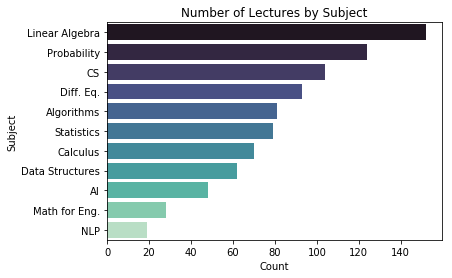

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
lectures = pd.read_csv('raw_text.csv')
subject_counts = lectures.label.value_counts().reset_index()
sns.barplot(x='label', y='index', data=subject_counts, palette='mako')
plt.ylabel('Subject')
plt.xlabel('Count')
plt.title('Number of Lectures by Subject')
plt.show()

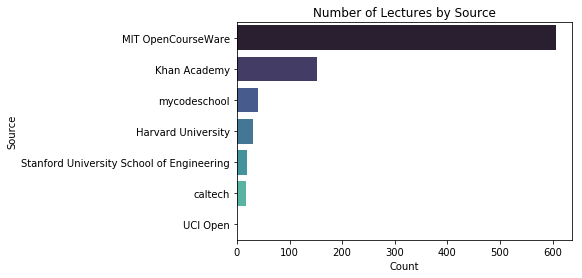

In [110]:
chan_cnt = base_df.channelid.value_counts().reset_index()
sns.barplot(x='channelid',y='index',data=chan_cnt, palette='mako')
plt.xlabel('Count')
plt.ylabel('Source')
plt.title('Number of Lectures by Source')
plt.show()


### Tokenizing the text

After cleaning, this what the data looks like:

In [111]:
lectures.head()

,text,label
0,The following content is\nprovided under a Cre...,Calculus
1,"In this sequence of segments,\nwe review some ...",Probability
2,The following content is\nprovided under a Cre...,CS
3,The following\ncontent is provided under a Cre...,Algorithms
4,The following\ncontent is provided under a Cre...,Algorithms


In [112]:
lectures.shape

(860, 2)

It is important to note that I used a few differnt tokenizing schemes, but ultimately ended up with this method:

In [113]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation

In [114]:
def tokenize(text):   
    #Clip the beginning
    text = text.lower() #set lower case
    text = text[295:] #remove first 295 characters
    text = text.replace('\n',' ') #remove the return
    rext = text.replace(' -- ', '') #other annoying punctuation
    #replace contractions
    for key, expand in contract_dict.items():
        text = text.replace(key, ' {} '.format(expand))
    #remove stop words    
    text = [w for w in word_tokenize(text) if not w in set(stopwords.words('english'))]
    #remove punctuation
    text = [w for w in text if not w in set(punctuation)]
    return text

In [121]:
pd.read_csv('tokenized.csv').head(1)

,text,label,tokens
0,The following content is\nprovided under a Cre...,Calculus,"['professor', 'professor', 'jerison', 'relaxin..."


This function takes in a string, in our case the lecture text and returns a list of tokens for each lecture. Now depending on what form the data needs to be in for the model. We can either leave the list of tokens or return to a string.

another format that I used for the neural nets and doc2vec was:

In [116]:
def make_d2v_data(lectures):
    clean_lectures = []
    #iterate over the text by lecture
    for lecture in lectures:
        #skip intro
        lecture = lecture[295:]
        #tokenize punctuation
        for key, token in punt_dict.items():
            lecture = lecture.replace(key, ' {} '.format(token))
        #expand contractions
        for key, expan in contract_dict.items():
            lecture = lecture.replace(key, ' {} '.format(expan))
        #append clean lecture to list of lectures
        clean_lectures.append(lecture)        
    return clean_lectures

This function leaves the stop words, expands contractions and replaces punctuation with an identifier. We add this to the dataframe to get:

In [130]:
lectures = pd.read_csv('all_lecture_text.csv')
lectures.head()

,Subject,title,d2v_text
0,Calculus,"Lec 39 | MIT 18.01 Single Variable Calculus, F...",PROFESSOR: So ||Comma|| ||Return|| Professor...
1,Probability,S01.0 Mathematical Background Overview,concepts ||Period|| I should say that ||Retur...
2,CS,8. Object Oriented Programming,FESSOR: All right everyone ||Period|| Let's g...
3,Algorithms,Recitation 9b: DNA Sequence Matching,OFESSOR: The things we ||Return|| can talk abo...
4,Algorithms,R10. Quiz 1 Review,FESSOR: All right ||Period|| So I brought a f...


# Training the Doc2Vec model.

the full training notebook can be found here: https://github.com/ExtraLime/math_lectures2/blob/master/d2v_model_cluster_cosine.ipynb

Now that we have our data ready, we need to train a model with it. The first model we will use is Doc2Vec. Doc2Vec is a method that was presented in 2014 by Mikolov and Le from google. It offers a way to embed paragraph in a similar manner to word2vec, but with a distributed memory. We will use the gensim implementation.

The Doc2Vec model takes a list of TaggedDocuments

In [131]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split

In [132]:
#Split the df for training and testing
train, test = train_test_split(lectures.reset_index(drop=True), test_size=.30, random_state=43)

#The Doc2Vec model takes 'tagged_documents'
#tag the training data
tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),\
tags=[str(i)]) for i, _d in enumerate(train.d2v_text)]

#tag testing data
tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()),\
tags=[str(i)]) for i, _d in enumerate(test.d2v_text)]

In [133]:
len(tagged_tr),len(tagged_test)

(602, 258)

Here is how we instantiate the model:

In [ ]:
#Instantiate the model

model = Doc2Vec(vector_size=100, # 100 should be fine based on the standards
                window=5, #change to 8
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=2, #ignores all words with total frequency lower than this.
                dm =1, #algorith 1=distributed memory
                workers=16)#cores to use

#build the vocab on the training data
model.build_vocab(tagged_tr)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
sns.set(style='dark', context='talk')


#Train the model
tsne = TSNE(2, random_state=43)
#max training epochs
max_epochs = 100
sil_scores = []
#train n epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch+1))
    model.train(tagged_tr,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
    #print every 5 epochs
    if epoch%25 == 0:
        vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_tr))])
        tsne_df = tsne.fit_transform(vecs)
        plt.figure(figsize=(12,9))
        sns.scatterplot(x=tsne_df[:,0],y=tsne_df[:,1],hue=train.Subject, legend='full')
        plt.legend(prop={'size': 8},bbox_to_anchor=[1,1])
        plt.show()

print("done!")
t2 = time.time()    
model.save("full_lects.model")
#print("Model Saved")
print("Time: {}".format(t2-t1))

I trained the model for 100 epochs, this choice was based on examples from the documentation and trial and error. Also it printed out some metrics every 25 epochs as well.

model = Doc2Vec.load("full_lects.model")

The model is a Doc2Vec object that has been trained for 100 epochs on 602 lectures. It also has an enebedding that contains vector respresentations for the 602 lectures it trained on. We can see them like this:

In [144]:
vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_tr))])
vecs.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-3.950238,1.592350,-0.628091,3.393130,-0.743619,-1.807064,-3.498028,-5.167349,-0.580078,3.835428,...,2.107881,4.42916,0.461291,-1.384528,2.563747,-0.334529,0.340319,-0.762466,5.096319,3.467194
1,5.495648,-0.841423,-3.057792,0.490489,1.481643,0.162223,1.255801,-6.406425,-1.465073,4.282125,...,2.106796,1.66831,-6.130185,-3.451396,-0.562176,3.271987,16.420599,1.014614,-2.887628,0.261940


Where each row represents a lecture and each column represents one feature of the 100 dimension vector space.

In [145]:
#We can also confirm the shape of the data.
vecs.shape

(602, 100)

In order to get vectors for the rest of the lectures we need to use the Doc2Vec '.infer_vector' method. This will vectorize previously unseen lectures. We will also create our train,test sets

In [160]:
# Extract vectors from doc2vec model
X_train = vecs
y_train = train.Subject

# Extract test values
X_test = pd.DataFrame([model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])
y_test = test.Subject

#reconstruct the lectures in vector form
X = pd.concat([X_train,X_test],axis=0)
y = pd.concat([y_train,y_test],axis=0)
X.shape,y.shape

((860, 100), (860,))

### Visualizing the vectors with t-SNE

t-SNE stands for t-distributed stochastic neighborhood embedding. It is a great way to visualize data with many dimensions. Check it out here https://lvdmaaten.github.io/tsne/  

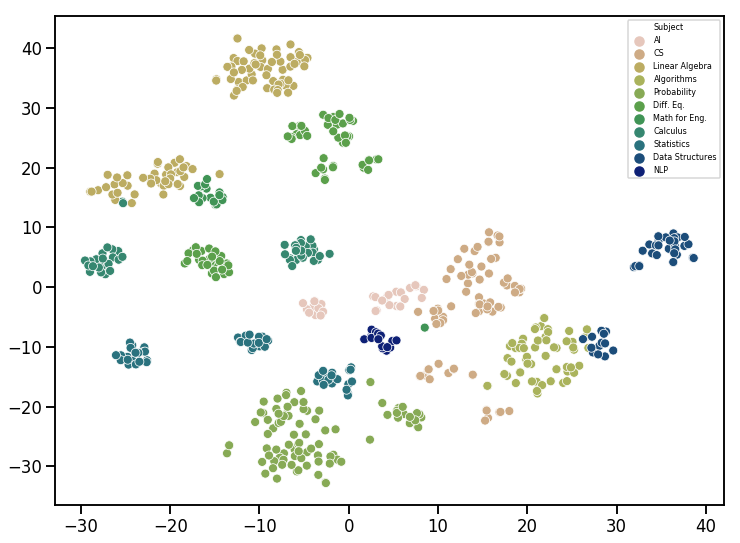

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne = TSNE(2, random_state=18)
tsne_df = tsne.fit_transform(vecs)

sns.set_context('talk')
plt.figure(figsize=(12,9))
sns.scatterplot(x=tsne_df[:,0],y=tsne_df[:,1],hue=train.Subject,palette='gist_earth_r', legend='full')
plt.legend(prop={'size': 8}, bbox_to_anchor=[1,1])
plt.show()

As we can see, the t-sne does a fantasic job of mapping the lectures in their respective groups near by.  However this is also a result of how well the Doc2Vec model vectorized each lecture. This representation of the lectures seems to indicate the model was able to descriminate between playlist_ids not just hand labled subjects.

# Clustering the Doc2Vec vectors

Using the vector representations of our lectures from the Doc2Vec model, we can run clustering algorithms on the data.
I tried a few different clustering methods, however, only the K Means and agglomerative algorithms were able to return results. I attemped, mean shift, affinity propagation, spectral, K Means and agglometrative algorithms.  Below are the results of the K Means clustering algorithm.  You can see other attemps in the full notebook linked above.

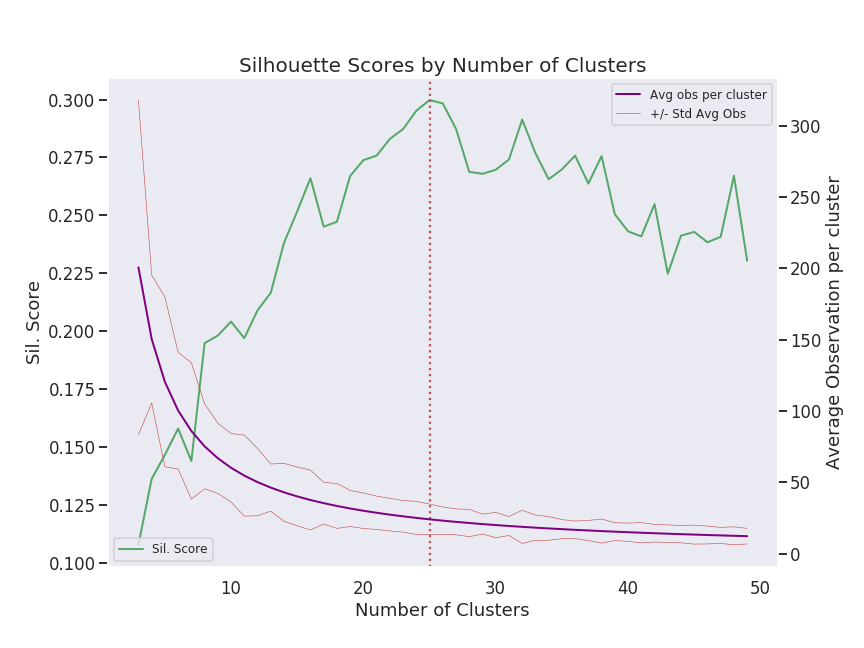

In [182]:
from IPython.display import Image
Image(filename='silscorest.png') 

This is what the clustering of the training set looks like. The graph is showing the silhouette score for different values for the number of clusters sought. For example, here the maximum silhouette score achieved was .2998 with 25 clusters.

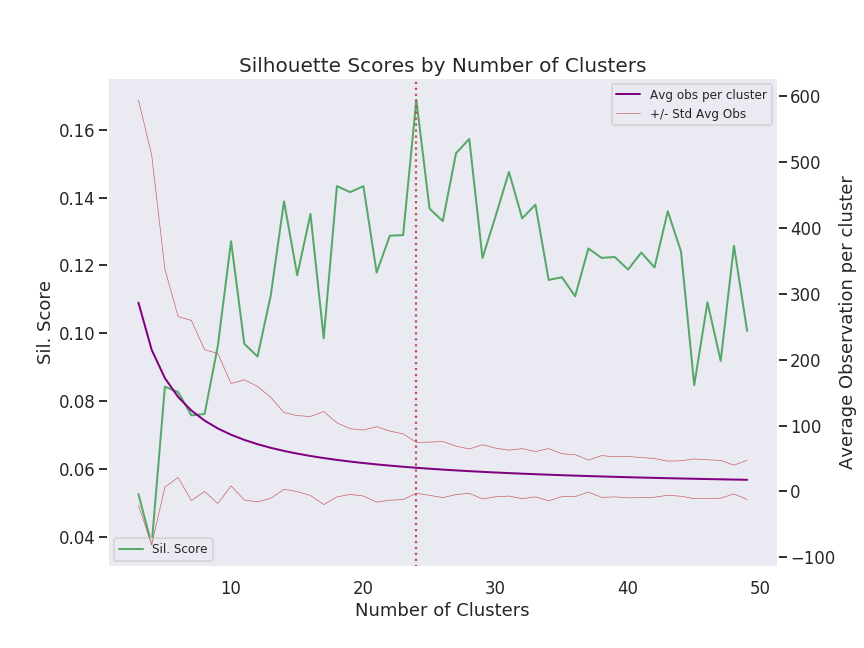

In [183]:
Image(filename='silscoreste.png')

When we cluster the test only, it finds a maximum silhouette score of .1688 with 24 clusters.

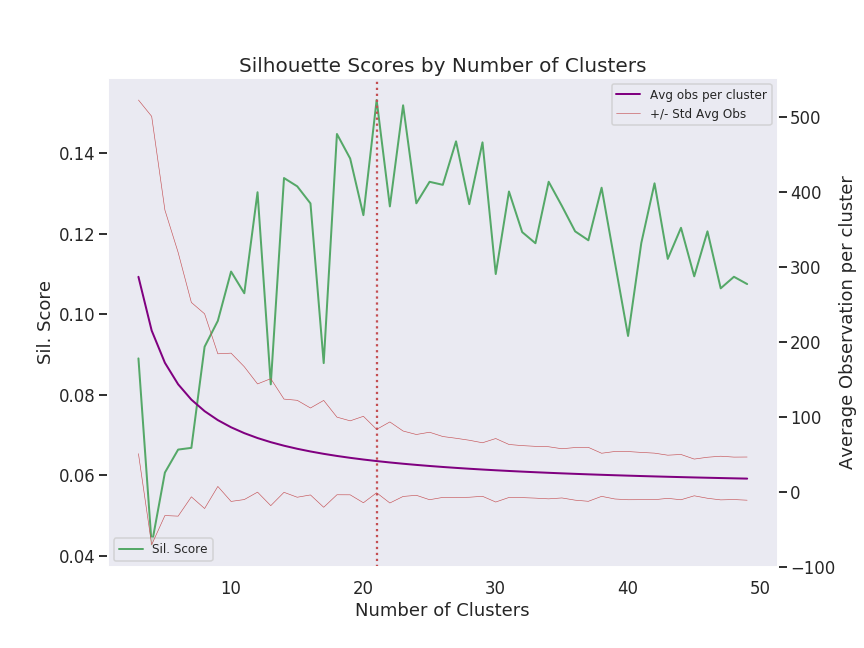

In [185]:
Image(filename='silscorestall.png')

When the enitre dataset is clustered the maximum silhouette score is .1532 with 21 clusters.  It is interesting to note that 21 clusters is somewhat supported by the t-sne visualization above. 
Overall, the silhouette scores were low and seemed to isolate the lecture playlists not the subjects. Here is a visualization of the clusters assigned by the algorithm.

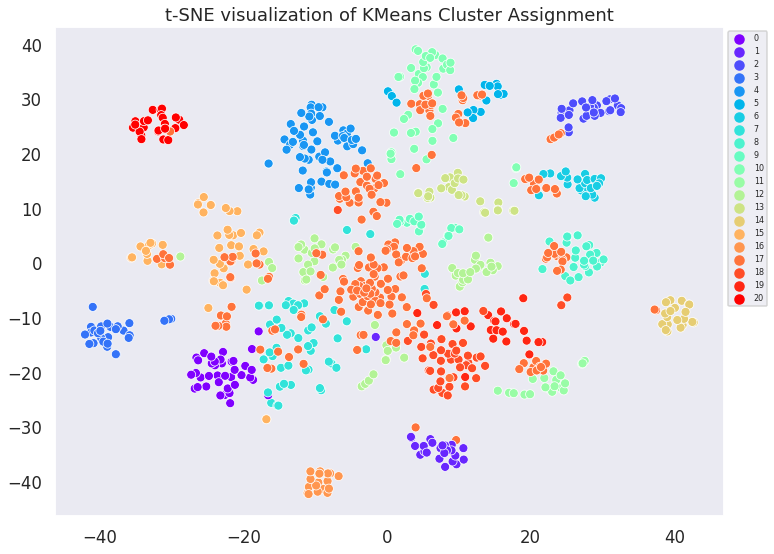

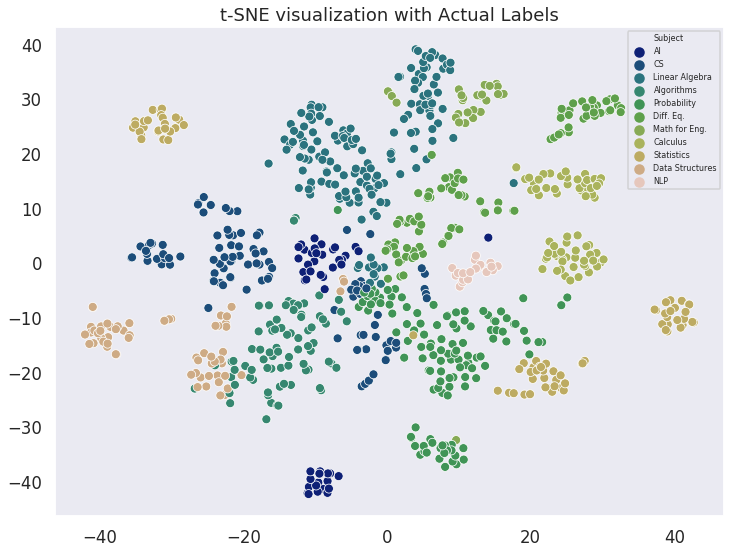

In [191]:
kclusters = cluster.KMeans(n_clusters=21, random_state=43).fit_predict(X)
tsne_df = tsne.fit_transform(X)
sns.set_context('talk')

plt.figure(figsize=(12,9))
sns.scatterplot(x=tsne_df[:,0],y=tsne_df[:,1],hue=kclusters,palette='rainbow', legend='full')
plt.legend(prop={'size': 8}, bbox_to_anchor=[1,1])
plt.title('t-SNE visualization of KMeans Cluster Assignment')
plt.show()

plt.figure(figsize=(12,9))
sns.scatterplot(x=tsne_df[:,0],y=tsne_df[:,1],hue=y,palette='gist_earth', legend='full')
plt.legend(prop={'size': 8}, bbox_to_anchor=[1,1])
plt.title('t-SNE visualization with Actual Labels')
plt.show()

# Cosine Similarity

Another metric we can use for our data is the cosine similarity. It works by calculating how similar each lecture is to every other lecture. The idea behind cosine similarity is that each lecture represents a vector in our model's vector space. By calculating the angle between the two vectors at the origin and taking the cosine of that angle. We will receive a maximum value of 1, meaning the two items are identicle, the further below 1 the less similar. We can construct the cosine similarity matrix like so:

In [213]:
from sklearn.metrics.pairwise import cosine_similarity
full_t = np.concatenate([train.title,test.title],axis=0)
d2v_fullsim = pd.DataFrame(cosine_similarity(X), index=full_t, columns=full_t)
print(d2v_fullsim.shape)
d2v_fullsim.iloc[:5,:5]

(860, 860)


,2. Reasoning: Goal Trees and Problem Solving,Functions as Arguments,"Lec 8 | MIT 18.06 Linear Algebra, Spring 2005",R9. Approximation Algorithms: Traveling Salesman Problem,R8. Simulation Algorithms
2. Reasoning: Goal Trees and Problem Solving,1.000000,0.280849,0.037819,0.274961,0.093424
Functions as Arguments,0.280849,1.000000,0.069861,0.288418,0.266519
"Lec 8 | MIT 18.06 Linear Algebra, Spring 2005",0.037819,0.069861,1.000000,-0.000742,0.122166
R9. Approximation Algorithms: Traveling Salesman Problem,0.274961,0.288418,-0.000742,1.000000,0.138615
R8. Simulation Algorithms,0.093424,0.266519,0.122166,0.138615,1.000000


We can add informative columns as well. I added the subject of each lecture, and calculated the mean similarity of each lecture. The mean similarity is a way of getting an idea of the relative similarity of a given lecture. Mathematically it is simply the mean of the similarity scores between one lecture and every other lecture.

In [214]:
full_y = np.concatenate([train.Subject,test.Subject],axis=0)
#Calculate mean similarity
d2v_fullsim.insert(0, 'mean_similarity', d2v_fullsim.mean(axis=1))

#add identification to similarity dataframe
d2v_fullsim['Subject'] = full_y

We can check out the most similar lectures for a given lecutre:

In [238]:
#test the response on a lecture
lecture = train.title[72]
d2v_fullsim[[lecture,'Subject','mean_similarity']].sort_values(by=[lecture],ascending=False)[:5]

,S01.1 Sets,Subject,mean_similarity
S01.1 Sets,1.000000,Probability,0.197822
S01.2 De Morgan's Laws,0.755756,Probability,0.169358
L01.6 More Properties of Probabilities,0.658494,Probability,0.192858
S01.10 Bonferroni's Inequality,0.654640,Probability,0.168360
L01.5 Simple Properties of Probabilities,0.608040,Probability,0.169628


We can also at the lectures that are the most similar, or 'representative' of our collection.

In [239]:

d2v_fullsim.sort_values(by='mean_similarity',ascending=False)[['mean_similarity','Subject']][:10]

,mean_similarity,Subject
Class Definition,0.381430,CS
For Loops,0.379071,CS
Python vs. Math,0.373426,CS
String Manipulations,0.371164,CS
Example of finding matrix inverse | Matrix transformations | Linear Algebra | Khan Academy,0.368092,Linear Algebra
Matrices: Reduced row echelon form 2 | Vectors and spaces | Linear Algebra | Khan Academy,0.364574,Linear Algebra
Multiplying a vector by a scalar | Vectors and spaces | Linear Algebra | Khan Academy,0.358810,Linear Algebra
S01.4 When Does a Sequence Converge,0.355109,Probability
L04.1 Lecture Overview,0.347093,Probability
2nd order linear homogeneous differential equations 2 | Khan Academy,0.346447,Diff. Eq.


To get an overall sense of the similarity between the items in our colection, we can visualize it with a heatmap.

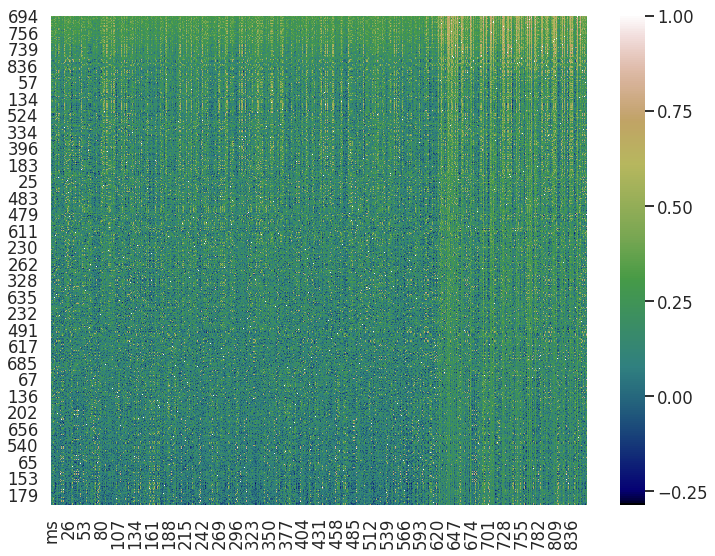

In [248]:
from sklearn.metrics.pairwise import cosine_similarity
heat = pd.DataFrame(cosine_similarity(X))
heat.insert(0, 'ms',heat.mean(axis=1))

plt.figure(figsize=(12,9))
sns.heatmap(heat.sort_values(by='ms',ascending=False),cmap='gist_earth')

The logic behind the cosine similarity can be applied to practicle problems, like search engines, recommendation systems, or any other situation where you would like to identify items similar to one in question.

It is interesting to note that the vectors generated as inferences from the model, tend to be more similar on average. This could be a result of the limited scope of the models ability to create a vector outside of what it knows.

In [2]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_test.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

#  Multiclass Classification

The main objective of this project is compare Doc2Vec and Tf-idf with respects to thier ability to classify documents by subject.

A number of models were explored. Through previous experience in this domain and general applicability, I decided to compare 4 models.
1. Logistic Regression (ridge)
2. Support Vector Classifier
3. RandomForest Classifier
4. Gradient Boosting Classifier

The results of each model can seen in the full notebook linked above. The best performer was the logistic regression with .94 average f1 score.

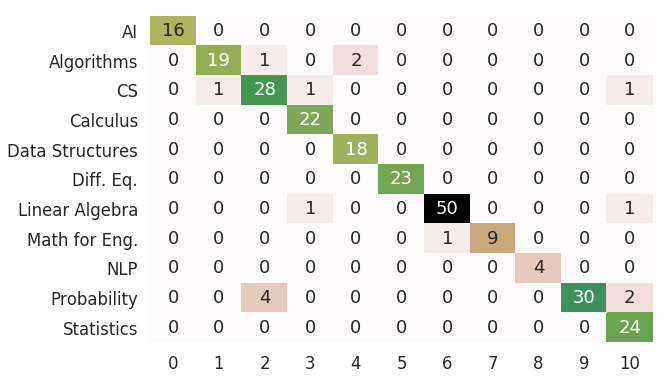

                 precision    recall  f1-score   support

             AI       1.00      1.00      1.00        16
     Algorithms       0.95      0.86      0.90        22
             CS       0.85      0.90      0.88        31
       Calculus       0.92      1.00      0.96        22
Data Structures       0.90      1.00      0.95        18
      Diff. Eq.       1.00      1.00      1.00        23
 Linear Algebra       0.98      0.96      0.97        52
  Math for Eng.       1.00      0.90      0.95        10
            NLP       1.00      1.00      1.00         4
    Probability       1.00      0.83      0.91        36
     Statistics       0.86      1.00      0.92        24

      micro avg       0.94      0.94      0.94       258
      macro avg       0.95      0.95      0.95       258
   weighted avg       0.95      0.94      0.94       258



In [255]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
lrc = LogisticRegression(C=30,solver='saga',max_iter=3000, multi_class='multinomial')
lrc.fit(X_train,y_train)
y_pred = lrc.predict(X_test)
heatconmat(y_test,y_pred)


The model proves to be quite accurate. The confusion between some of the lectures is quite understandable. For instance the model labels two lectures from Data Structure as Algorithms. This is understandable because ALgorithms and Data Structures initmately related. Some other incorrect labels occured between Statistics and Probability, again understandable. One less explainable observation is the four lectures the model labelled as Probability when the true labels were computer science.

# Training the Tf-idf model
Here I will perform the same tasks but with a Term Frequency-Inverse Document Frequency model. 

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import cluster
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
tsne = TSNE(2)
import seaborn as sns
sns.set(context='talk',style='dark',palette='gist_earth')

In [84]:
lectures.head()

,Subject,title,d2v_text
0,Calculus,"Lec 39 | MIT 18.01 Single Variable Calculus, F...",PROFESSOR: So ||Comma|| ||Return|| Professor...
1,Probability,S01.0 Mathematical Background Overview,concepts ||Period|| I should say that ||Retur...
2,CS,8. Object Oriented Programming,FESSOR: All right everyone ||Period|| Let's g...
3,Algorithms,Recitation 9b: DNA Sequence Matching,OFESSOR: The things we ||Return|| can talk abo...
4,Algorithms,R10. Quiz 1 Review,FESSOR: All right ||Period|| So I brought a f...


In [85]:
lectures = pd.read_csv('all_lecture_text.csv')

X = lectures.d2v_text
y = lectures[['Subject','title']]

In [86]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=43)

I chose my minimun document frequency based on some preliminary tests. the can be found in the tfidf clustering notebook.

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                             min_df=25, # only use words that appear at least 25
                             stop_words='english', #use english stopwords
                             lowercase=True, #lowercase
                             use_idf=True, #idf
                             norm=u'l2',  #normalization
                             smooth_idf=True)#add 1 to all words to prevent 0 division

X_train_idf = vectorizer.fit_transform(X_train)
X_test_idf = vectorizer.transform(X_test)
X_idf = np.concatenate([X_train_idf.todense(),X_test_idf.todense()],axis=0)
y_test_a = pd.concat([y_train,y_test],axis=0)    

# Clustering with Tf-idf

While clustering with the tf-idf vectors, I wrote a loop that iterates over different settings for minimum document frequency then attemps to cluster the data with cluster numbers ranging from 3-50 clusters. You can see the full code in this notebook https://github.com/ExtraLime/math_lectures2/blob/master/tfidf_clustering.ipynb. An example is below of how we can attempt to find the best number of clusters by silhouette score and then visualize the labeled results with t-sne:

tfidf min_df: 29
Best Number of Clusters: 47, Sillhouette score:0.1987567418839915


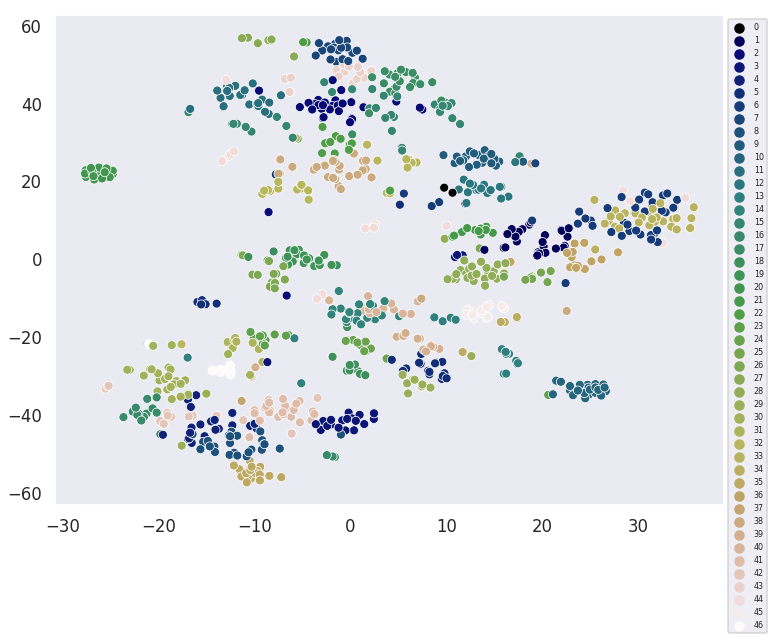

In [62]:
fnclusts = []
fsscores = [] 
for no in range(8,50,3):        
        kmeans = cluster.KMeans(n_clusters=no).fit_predict(X_idf)    
        fnclusts.append(no)
        fsscores.append(silhouette_score(X_idf, kmeans, metric='cosine'))
#for each round of clustering, print the best performer and t-SNE  
print("tfidf min_df: {}".format(number))
print('Best Number of Clusters: {}, Sillhouette score:{}'.format(fnclusts[np.argmax(fsscores)],max(fsscores)))
kmeans = cluster.KMeans(n_clusters=fnclusts[np.argmax(fsscores)]).fit_predict(X_idf)
tsne_df = tsne.fit_transform(X_idf)
plt.figure(figsize=(12,9))

sns.scatterplot(x=tsne_df[:,0],y=tsne_df[:,1],hue=kmeans, legend='full', palette='gist_earth')
plt.legend(prop={'size': 8}, bbox_to_anchor=[1,1])
plt.show()

Clustering the data with KMeans and Agglomerative again were the only feasible options. However, the results are not very interpretable both in terms of number of clusters and low silhouette scores. With every attempt, the silhouette score increases with a higher minimum document frequency and number of clusters. This may have to do with the fact that KMeans clustering does not usually perform well with data that has non-flat geometry.

# Cosine Similarity with Tf-idf
You can see the full code in this notebook :
https://github.com/ExtraLime/math_lectures2/blob/master/tfidf_clustering.ipynb

In [67]:
tf_sim = pd.DataFrame(cosine_similarity(X_idf), index=y['title'], columns=y['title'])
#calculate the mean similarity between lectures
tf_sim.insert(0, 'mean_similarity', tf_sim.mean(axis=1))
#add identification to similarity dataframe
tf_sim['Subject'] = list(lectures.Subject)

In [70]:
#test the response on a lecture
lecture = lectures.title[102]
tf_sim[[lecture,'Subject','mean_similarity']].sort_values(by=[lecture],ascending=False)[:6]

title,12. Searching and Sorting,Subject,mean_similarity
title,,,
12. Searching and Sorting,1.000000,CS,0.061224
"Lec 11 | MIT 18.03 Differential Equations, Spring 2006",0.807756,Diff. Eq.,0.088173
Separable differential equations introduction | First order differential equations | Khan Academy,0.679089,Diff. Eq.,0.067182
Defining the angle between vectors | Vectors and spaces | Linear Algebra | Khan Academy,0.633961,Linear Algebra,0.095111
4. Geometric Structures II,0.628071,Data Structures,0.078671
"Lecture 12: Discrete vs. Continuous, the Uniform | Statistics 110",0.626402,Statistics,0.065624


In [72]:
tf_sim.sort_values(by='mean_similarity',ascending=False)[['mean_similarity','Subject']][:5]

title,mean_similarity,Subject
title,,
R23. Computational Complexity,0.124946,Algorithms
9. Constraints: Visual Object Recognition,0.122635,AI
"Lec 18 | MIT 6.042J Mathematics for Computer Science, Fall 2010",0.119459,CS
Adding vectors | Vectors and spaces | Linear Algebra | Khan Academy,0.119021,Linear Algebra
22. Ideal Quantum Gases Part 2,0.118563,Statistics


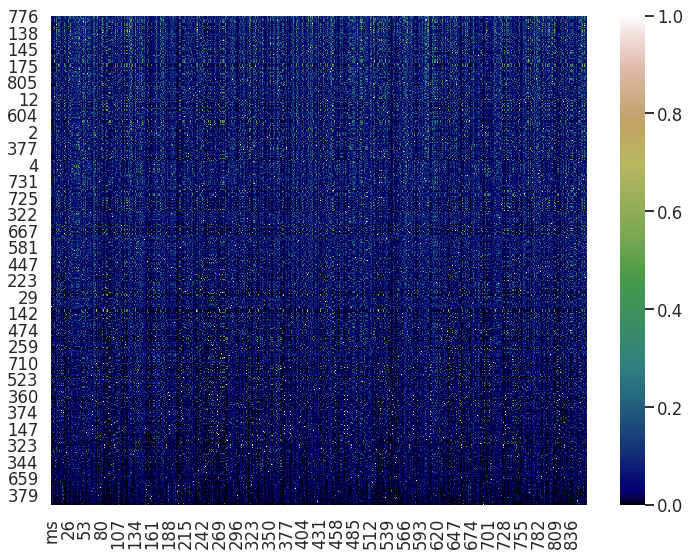

In [76]:
heat = pd.DataFrame(cosine_similarity(X_idf))
heat.insert(0, 'ms',heat.mean(axis=1))

plt.figure(figsize=(12,9))
sns.heatmap(heat.sort_values(by='ms',ascending=False),cmap='gist_earth')
plt.show()

Here we note that the cosine similarity overall very low in the tfidf model. This is an advantage for classification as the model is able to discrimiate subjects more distinctly. Also note that the top etries for the mean similarity are all different which contrasts with the Doc2Vec model.

# Tf-idf Classifier

You can see the whole modling notebook here: https://github.com/ExtraLime/math_lectures2/blob/master/tfidf_modeling.ipynb

The best performer was the Logistric Regression again.

In [102]:
X = lectures.d2v_text
y = lectures['Subject']

In [103]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=43)

In [104]:
vectorizer = TfidfVectorizer(max_df=0.50, # drop words that occur in more 50% of the sentences
                             min_df=25, # only use words that appear at least 25
                             stop_words='english', #use english stopwords
                             lowercase=True, #lowercase
                             use_idf=True, #idf
                             norm=u'l2',  #normalization
                             smooth_idf=True)#add 1 to all words to prevent 0 division

X_train_idf = vectorizer.fit_transform(X_train)
X_test_idf = vectorizer.transform(X_test)

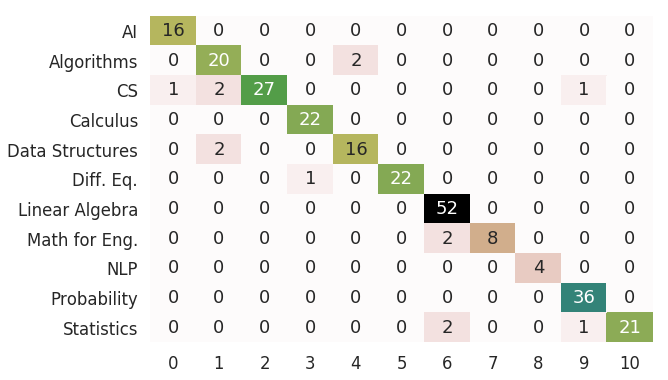

                 precision    recall  f1-score   support

             AI       0.94      1.00      0.97        16
     Algorithms       0.83      0.91      0.87        22
             CS       1.00      0.87      0.93        31
       Calculus       0.96      1.00      0.98        22
Data Structures       0.89      0.89      0.89        18
      Diff. Eq.       1.00      0.96      0.98        23
 Linear Algebra       0.93      1.00      0.96        52
  Math for Eng.       1.00      0.80      0.89        10
            NLP       1.00      1.00      1.00         4
    Probability       0.95      1.00      0.97        36
     Statistics       1.00      0.88      0.93        24

      micro avg       0.95      0.95      0.95       258
      macro avg       0.95      0.94      0.94       258
   weighted avg       0.95      0.95      0.95       258



In [108]:
lrc = LogisticRegression(C=100,solver='lbfgs',multi_class='multinomial',max_iter=5000)
lrc.fit(X_train_idf.todense(),y_train)
y_pred = lrc.predict(X_test_idf.todense())
heatconmat(y_test,y_pred)

We can see that the tf-idf model edges out the Doc2Vec just by a few lectures, particularly in with the probability lectures.

# Conclusion

This was a broad overview of what can be done with supervised and unsupervised methods for document retreival, text classification and similarity. Cosine similarities can be used to build recommendation engines, clustering algorithms can help define cluster groups for say an unorganzied info@someco.com inbox. The modeling methods can be used to correctly assign technicians to help tickets based on the content.  These are just a few applications.
-Again this is just a recap notebook, it is accompanied by a presentation https://slides.com/will-m/deck/live#/ and a github repo with the links to more detailed notebooks. https://github.com/ExtraLime/math_lectures2/